# Obtencion de datos de suelo para Argentina, Uruguay, Paraguay y Chile

En esta notebook se vera un paso a paso de como se obtienen los datos de suelo de distintas fuentes y se cruzan con datos geograficos de zonas ecologicas y zonas de suelo.

Importacion de librerias necesarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from pyproj import Transformer
from soilgrids import SoilGrids
from functools import reduce
import subprocess
import os
from os.path import exists
import re
import pyscripts.utils as utils

from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )

## Wosis

Obtenemos los perfiles de las propiedades de carbono organico, arcilla, y bulk density de la base de datos de wosis. Para esto llamamos a un script en R que extrae la informacion de la base de datos. Se hace este proceso para cada pais y para cada material. 

In [10]:
countries = ['Argentina', 'Uruguay', 'Paraguay', 'Chile']
properties = ['profiles', 'orgc', 'clay', 'bdfi33']
path = 'wosis_latest/'

for country in countries:
    for prop in properties:
        filename = f'wosis_latest/wosis_latest_{prop}_{country}.shp'
        if not exists(filename):
            subprocess.call([f"sudo Rscript gdal_wosis.R {country} shp {prop}"], shell=True)
            print(f'{filename} generated')
        else :
            print(f'{filename} already exists')

wosis_latest/wosis_latest_profiles_Argentina.shp already exists
wosis_latest/wosis_latest_orgc_Argentina.shp generated
wosis_latest/wosis_latest_clay_Argentina.shp generated
wosis_latest/wosis_latest_bdfi33_Argentina.shp generated
wosis_latest/wosis_latest_profiles_Uruguay.shp already exists
wosis_latest/wosis_latest_orgc_Uruguay.shp generated
wosis_latest/wosis_latest_clay_Uruguay.shp generated
wosis_latest/wosis_latest_bdfi33_Uruguay.shp already exists
wosis_latest/wosis_latest_profiles_Paraguay.shp generated
wosis_latest/wosis_latest_orgc_Paraguay.shp generated
wosis_latest/wosis_latest_clay_Paraguay.shp generated
wosis_latest/wosis_latest_bdfi33_Paraguay.shp generated
wosis_latest/wosis_latest_profiles_Chile.shp generated
wosis_latest/wosis_latest_orgc_Chile.shp generated
wosis_latest/wosis_latest_clay_Chile.shp generated
wosis_latest/wosis_latest_bdfi33_Chile.shp generated


Cada archivo contiene informacion sobre perfiles. Nos interesa unicamente los primeros 30cm de cada perfil, por lo que vamos a reducir la informacion de cada dataset obtenido a un promedio para los primeros 30cm de cada perfil.

Definimos la funcion que vamos a usar para calcular el ponderado promedio de los primeros 30cm de cada perfil. Para esto nos ayudamos de las columnas 'upper_depth' y 'lower_depth', que respectivamente indican los limites superiores e inferiores de cada capa (cada fila) del dataset

In [18]:
df.columns

Index(['gml_id', 'profile_id', 'profile_la', 'country_na', 'upper_dept',
       'lower_dept', 'layer_name', 'litter', 'clay_value', 'clay_val_1',
       'clay_metho', 'clay_date', 'clay_datas', 'clay_profi', 'clay_licen',
       'geometry'],
      dtype='object')

In [2]:
def poderate_avg(profiles, property, limit):
    col = property + '_value_avg'
    if(profiles['upper_depth'] > limit):
        return 0.0 

    if(profiles['lower_depth'] > limit):
        partial_depth = limit - profiles['upper_depth']
        return (partial_depth * profiles[col])/limit
    else:
        return ((profiles['lower_depth'] - profiles['upper_depth']) * profiles[col])/limit

Luego definimos una funcion que agrupe todas las filas de un dataset segun cada perfil, y devuelva unicamente el promedio ponderado de los primeros 30 cm del perfil, para una property particular

In [3]:
def get_profile_summary(df, property):
    prop_pond_col = property + '_pond_val'
    df[prop_pond_col] = df.apply(poderate_avg, args=(property, 30), axis=1)
    return df[['profile_id', 'country_name', prop_pond_col]].groupby(['profile_id', 'country_name']).sum().reset_index()

Luego escaneamos el directorio con los archivos descargados desde wosis para unirlos en un unico dataset con toda la informacion sumarizada. 

In [26]:
## we compose a regular expression to help us search for the files we want to process
countries = '|'.join(['Argentina', 'Uruguay', 'Paraguay', 'Chile'])
properties = '|'.join(['clay', 'orgc', 'bdfi33'])
format = 'csv' # format is fixed

files_re = re.compile(f'wosis_latest_({properties})_({countries}).{format}')
files = []

## scan local directory for shape files
with os.scandir('./wosis_latest/') as entries:
    for entry in entries:
        if re.search(files_re, entry.name):
            print(entry.name)
            files.append(entry.name)

## read all files into pandas dataframes and get summary from each one
group = []
countries = {}
for file in files:
    if(format == 'csv'):
        df = pd.read_csv("./wosis_latest/" + file)
        property = file.split("_")[-2]
        country = file.split("_")[-1].split(".")[0]
        if country not in countries.keys():
            countries[country] = []
        countries[country].append(get_profile_summary(df, property))

## merge all dataframes
reduced_countries = {}
for key in countries:
    reduced_countries[key] = reduce(lambda l, r: pd.merge(l, r, on=['profile_id', 'country_name'], how='outer'), countries[key])
        
profille_summary = pd.concat(reduced_countries.values())
profille_summary

wosis_latest_clay_Argentina.csv
wosis_latest_orgc_Paraguay.csv
wosis_latest_orgc_Uruguay.csv
wosis_latest_bdfi33_Uruguay.csv
wosis_latest_clay_Chile.csv
wosis_latest_clay_Paraguay.csv
wosis_latest_clay_Uruguay.csv
wosis_latest_bdfi33_Argentina.csv
wosis_latest_orgc_Argentina.csv
wosis_latest_bdfi33_Paraguay.csv
wosis_latest_bdfi33_Chile.csv
wosis_latest_orgc_Chile.csv


,profile_id,country_name,clay_pond_val,bdfi33_pond_val,orgc_pond_val
0,63821,Argentina,45.533333,NaN,11.876667
1,63822,Argentina,12.500000,NaN,4.166667
2,63823,Argentina,16.133333,NaN,2.000000
3,63824,Argentina,31.666667,NaN,17.500000
4,63825,Argentina,10.533333,NaN,16.556667
...,...,...,...,...,...
10786,732831,Chile,NaN,NaN,127.310000
10787,732832,Chile,NaN,NaN,2.000000
10788,732833,Chile,NaN,NaN,1.000000
10789,732834,Chile,NaN,NaN,4.000000


In [27]:
profille_summary.country_name.value_counts()

Chile        10791
Argentina      249
Uruguay        136
Paraguay         1
Name: country_name, dtype: int64

## Obtencion de los valores de bulk_density estimados con Soilgrids

La base de datos de Wosis tiene muchos faltantes para los valores de bulk_density en los perfiles recuperados. Complementamos estos datos usando un archivo raster de soilgrids que contiene informacion estimada de bulk density. 

Hay un par de funciones por definir. En principio podemos obtener el bounding box para todos los paises pero posteriormente hay que convertir el sistema de coordenadas de uno elipsoidal a uno proyectado. Esto hace la funcion transform_crs.

Ademas, Soilgrids solo deja obtener la informacion de cierta profundidad de los perfiles. 0-5, 5-15 y 15-30. Vamos a obtener los raster para todas estas profundidades y, luego de samplear el raster, calculamos el ponderado. Lo hacemos de esta manera para evitar calcular el ponderado de muchos raster que no nos interesan. 

In [7]:
def transform_crs(crs_from, crs_to, bbox):
    t = Transformer.from_crs(crs_from=crs_from, crs_to=crs_to, always_xy=True)
    bbox[0], bbox[1] = t.transform(bbox[0], bbox[1])
    bbox[2], bbox[3] = t.transform(bbox[2], bbox[3])
    return bbox

def get_bulk_density(bbox, depth, file_id):
    # get data from SoilGrids
    soil_grids = SoilGrids()
    filename = f'soilgrids/{file_id}_{depth}_mean.tif'
    if not exists(filename):
        print('getting coverage data with bounding box:', bbox)
        return soil_grids.get_coverage_data(service_id='bdod', coverage_id=f'bdod_{depth}cm_mean', 
                                            west=bbox[0], south=bbox[1], east=bbox[2], north=bbox[3],                                     
                                            crs='urn:ogc:def:crs:EPSG::3857', local_file=False,
                                            output=filename)
    else: 
        return gpd.read_file(filename)

In [4]:
# split the bounding box to a matrix of boxes. they must all have negative coordinates
def bbox_split(bbox, splits):
    print('original bbox:', bbox)
    bboxes = []
    west_bound = bbox[0]
    south_bound = bbox[1]
    east_bound = bbox[2]
    north_bound = bbox[3]
    hdif = east_bound - west_bound
    vdif = north_bound - south_bound
    for i in range(splits):
        s = south_bound + i*hdif/splits
        n = s + hdif/splits
        for j in range(splits):   
            w = west_bound + j*hdif/splits
            e = w + hdif/splits
            bboxes.append([w, s, e, n])
    return bboxes

In [5]:
# gets bounding box for each country in country codes and transforms crs from 4326 to 3857
def get_bboxes_and_transform(country_codes=['AR', 'UY', 'PY', 'CL']):
    bboxes = []
    for country_code in country_codes:
        bbox = list([c.bbox for c in country_subunits_by_iso_code(country_code)][0]) # returns tuple inside list
        bboxes.append(transform_crs("epsg:4326", "epsg:3857", bbox))
    return bboxes

In [12]:
splits = 2
bddata = []

#for country_code in ['AR', 'UY', 'CL', 'PY']:
for country_code in ['AR']:
 #   for depth in ['0-5', '5-15', '15-30']:
    for depth in ['0-5']:
        bbox = list([c.bbox for c in country_subunits_by_iso_code(country_code)][0]) # returns tuple inside list
        bbox = transform_crs("epsg:4326", "epsg:3857", bbox)

        if country_code == 'AR':
            bboxes = bbox_split(bbox, splits)
            get_bulk_density(bboxes[0], depth, f'{country_code}_1')
           # for idx, bbox in enumerate(bboxes):
            #    bddata.append(get_bulk_density(bbox, depth, f'{country_code}_{idx}'))
        else:
            bddata.append(get_bulk_density(bbox, depth, country_code))

getting coverage data with bounding box: [-6505303.405015289, -4154754.3755499045, -5913913.174656795, -3516548.619345236]


ReadTimeout: HTTPSConnectionPool(host='maps.isric.org', port=443): Read timed out. (read timeout=30)

# Zonas Ecologicas

Obtenemos los nombres de las zonas ecologicas desde un archivo externo, y lo unimos a nuestro set de datos

In [64]:
with open('ecozone_names.txt', 'r') as ecozones:
    zones = ecozones.readlines()
zone_names = list(map(utils.zone_names, zones))
levels = list(map(utils.levels, zones))
df_level_zone = pd.DataFrame(list(zip(levels, zone_names)), columns=['level', 'zone_name'])
df_level_zone

,level,zone_name
0,13,Temperate Sierras
1,13.6,Central American Sierra Madre and Chiapas High...
2,13.6.1,Northern Central American Highlands
3,13.6.2,Central American Sierra Madre
4,13.6.4,Altos de Chiapas con bosque mesoÃ³filo
...,...,...
162,24.2,Patagonian Tablelands
163,24.2.1,Northern Patagonia
164,24.2.2,Southern Patagonia
165,24.2.3,Magellan Grasslands


<AxesSubplot: >

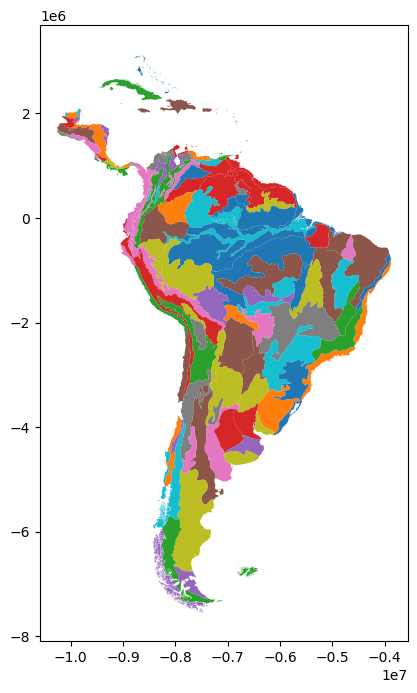

In [77]:
gdf_ecoregions = gpd.read_file("sa_eco_13/sa_eco_l3.shp").to_crs("EPSG:3857")
gdf_ecoregions = gdf_ecoregions.merge(df_level_zone, left_on='LEVEL3', right_on='level')
fig, ax = plt.subplots(1, 1, figsize=(15,8))
gdf_ecoregions.plot(column='zone_name', ax = ax)


## Zonas ecologicas para Argentina, Uruguay, Paraguay y Chile

In [68]:
def get_profiles_and_transform(countries=['Argentina', 'Uruguay', 'Paraguay', 'Chile']):
    gdfs = []
    for country in countries:
        file = f"wosis_latest/wosis_latest_profiles_{country}.shp"
        gdf = gpd.read_file(file)
        gdfs.append(gdf.to_crs("EPSG:3857"))
    return gdfs

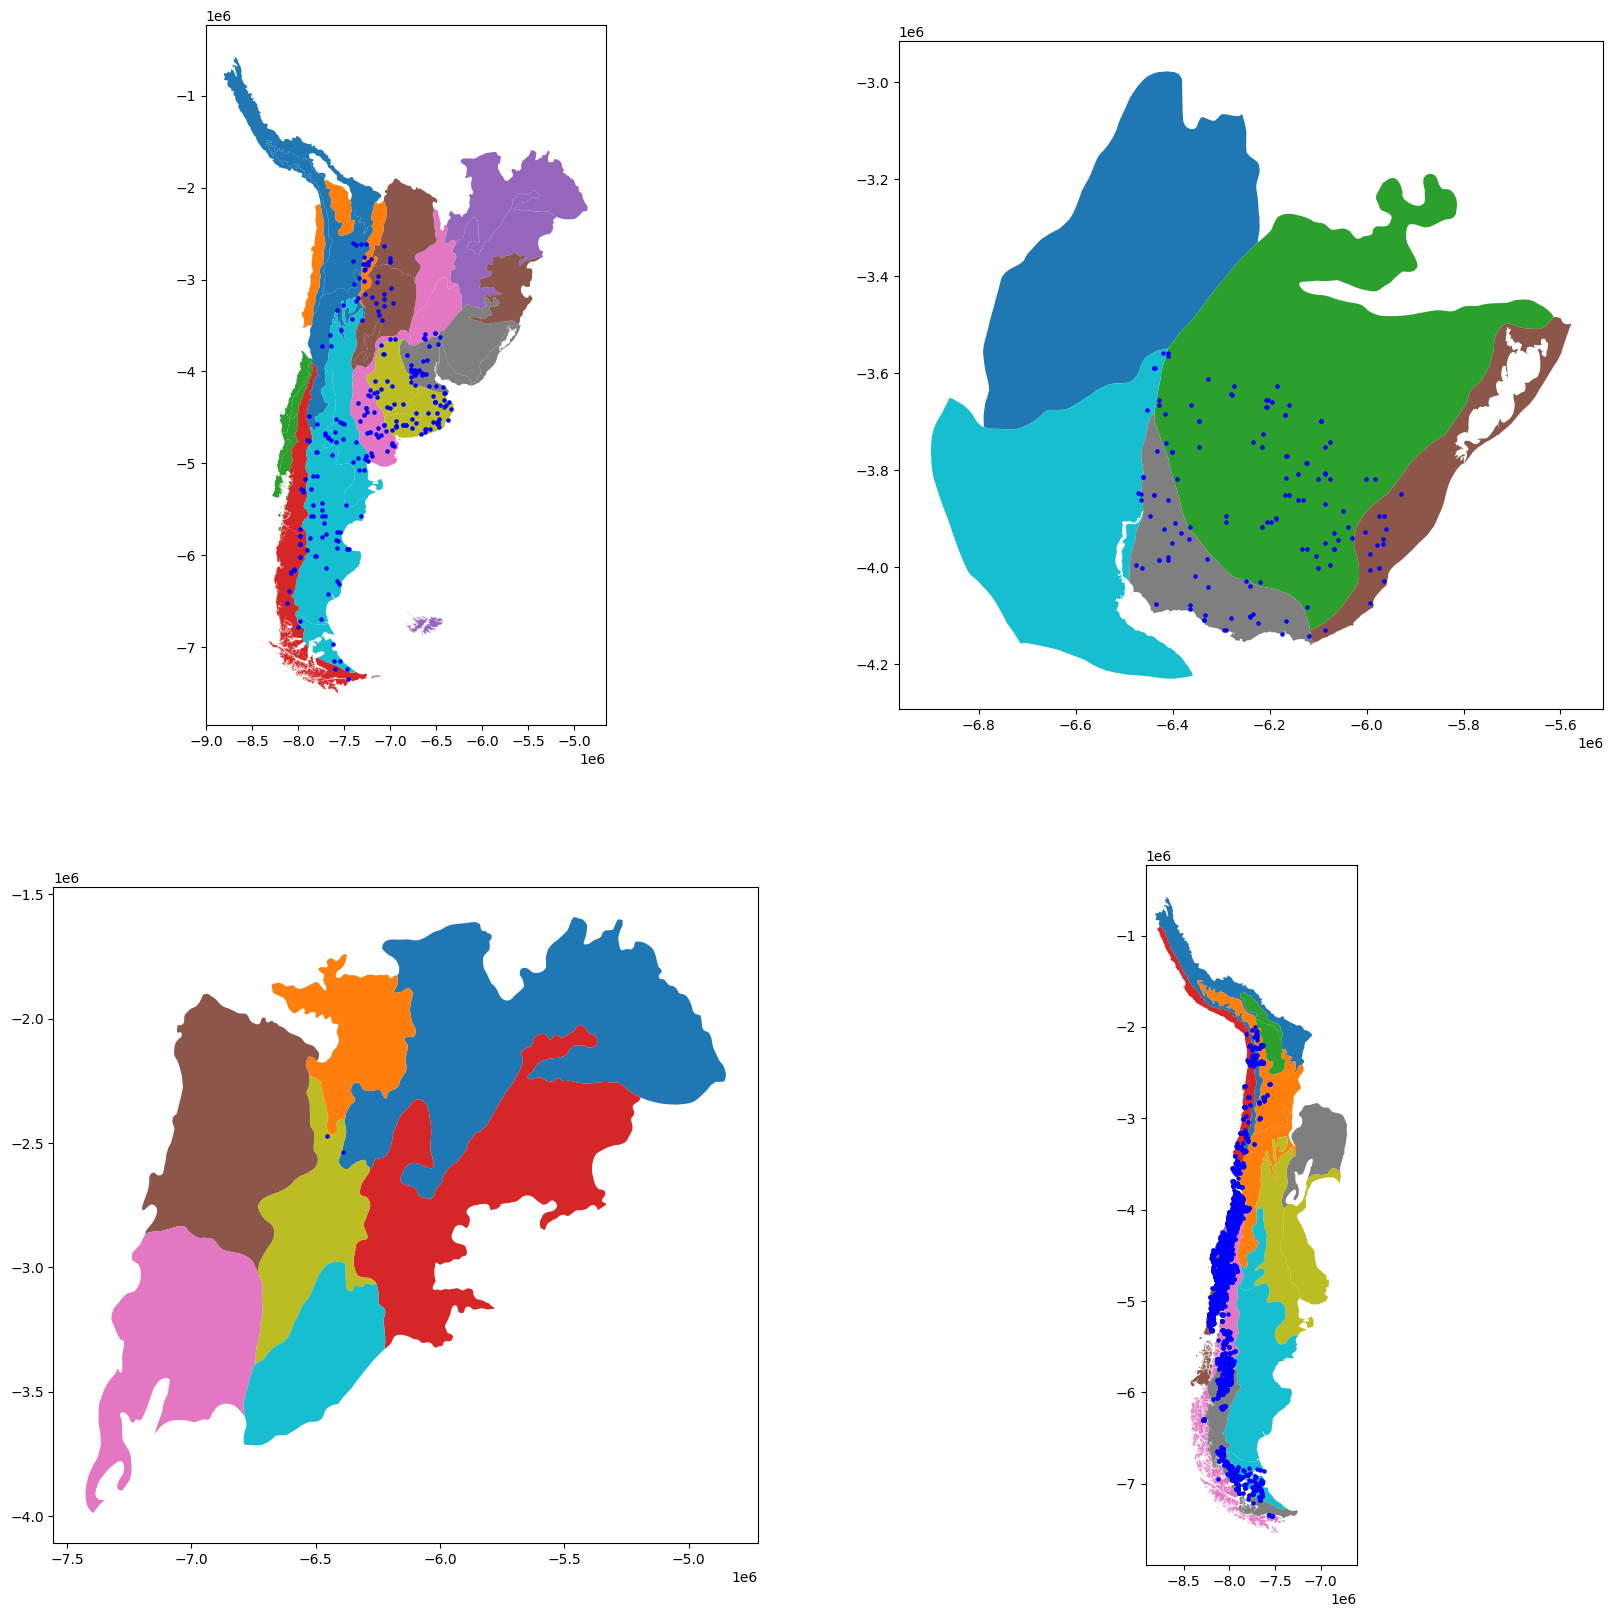

In [78]:
bboxes = get_bboxes_and_transform()
profiles = get_profiles_and_transform()
n = 2

fig, axes = plt.subplots(n, n, figsize=(20,20))

for i in range(n):
    for j in range(n):
        bbox = bboxes[j+i*n]
        base = gdf_ecoregions.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(column='level', ax=axes[i][j])
        profiles[j+i*n].plot(ax=base, marker='o', color='blue', markersize=5)

# Zonas de suelo

<AxesSubplot: >

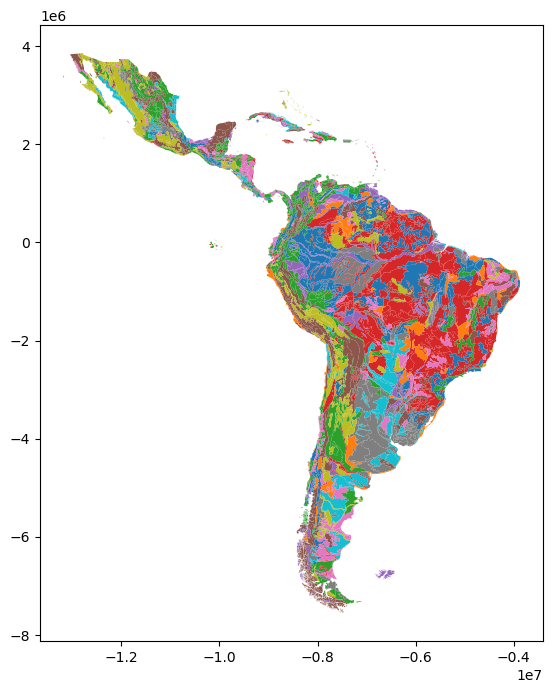

In [74]:
gdf_soils = gpd.read_file("LAC-SOTER/SOTERLAC/GIS/SOTER/SOTERLACv2.shp").to_crs("EPSG:3857")
fig, ax = plt.subplots(1, 1, figsize=(15,8))
gdf_soils.plot(column="DOMSOIL_UN", ax=ax)


### Zonas de suelo para Argentina, Uruguay, Paraguay y Chile

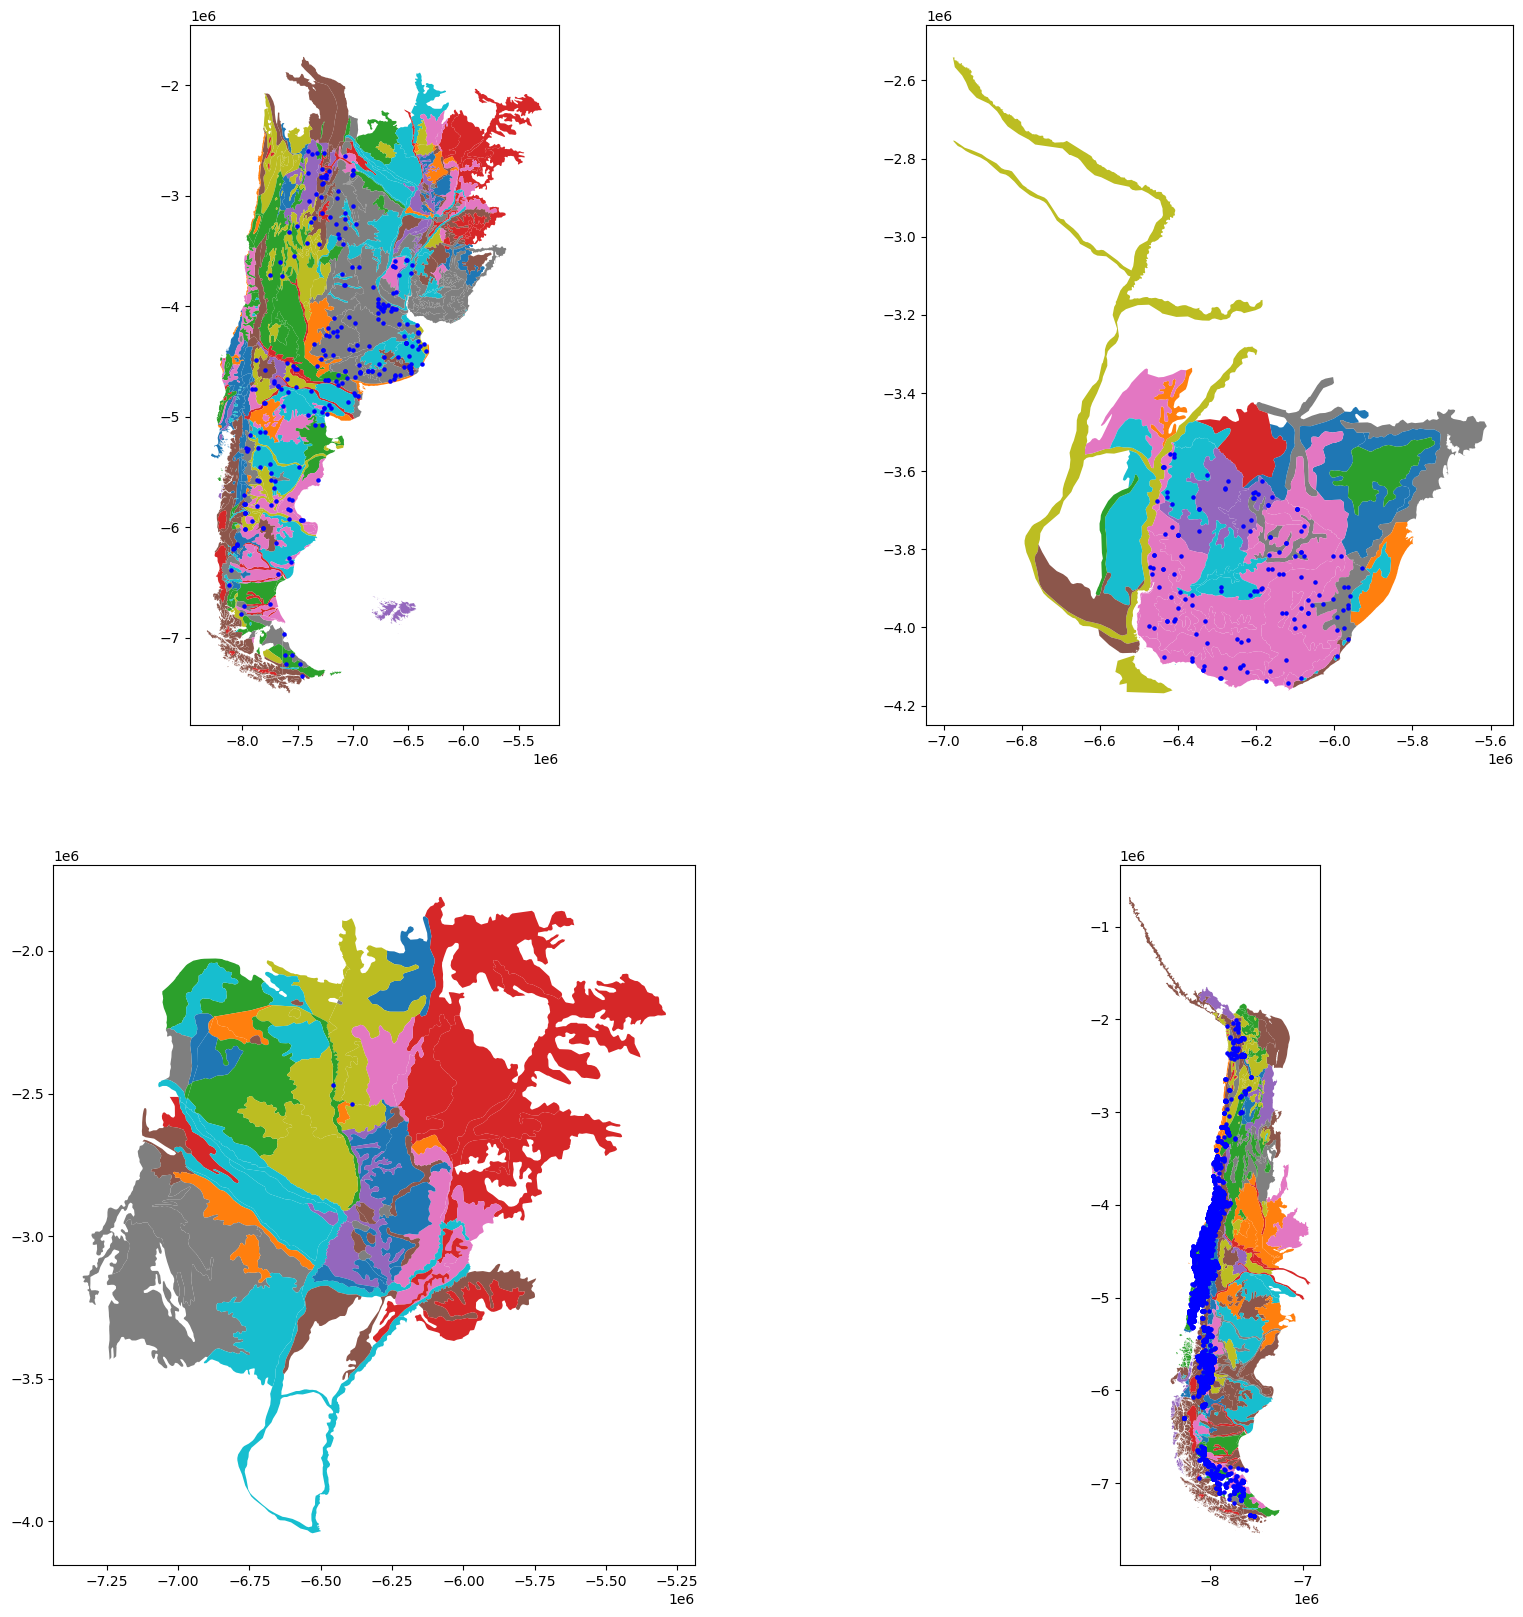

In [76]:
bboxes = get_bboxes_and_transform()
profiles = get_profiles_and_transform()
n = 2

fig, axes = plt.subplots(n, n, figsize=(20,20))

for i in range(n):
    for j in range(n):
        bbox = bboxes[j+i*n]
        base = gdf_soils.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(column='DOMSOIL_UN', ax=axes[i][j])
        profiles[j+i*n].plot(ax=base, marker='o', color='blue', markersize=5)

# Zonas de suelo cruzadas con Zonas ecologicas

In [79]:
gdf_all_zones = gdf_ecoregions.sjoin(gdf_soils, predicate='overlaps', how='inner')
gdf_all_zones

,AREA_left,PERIMETER_left,SA_ECO_ALB,SA_ECO_A_1,LEVEL3,LEVEL2,LEVEL1,Shape_Leng,Shape_Area,geometry,...,PERIMETER_right,SOTERLAC_,SOTERLAC_I,NEWSUID,LANDFORM,PARENT_MAT,NUMB_SOILC,COV_PERC_D,DOMSOIL_UN,DOMSOIL_WR
0,1.807720e+06,6852.72,2,2,16.1.1,16.1,16,6.852716e+03,1.807722e+06,"POLYGON ((-8720656.388 3150681.035, -8721114.0...",...,5992.269306,177,175,TC25,LP,SO1,2.0,60.0,LPe,None
1,5.750910e+05,3528.49,3,3,16.1.1,16.1,16,3.528488e+03,5.750906e+05,"POLYGON ((-8718599.338 3150123.543, -8719313.6...",...,3106.338350,178,176,BS25,LP,SO1,2.0,60.0,RGc,None
2,8.309400e+05,6550.06,4,4,16.1.1,16.1,16,6.550065e+03,8.309403e+05,"POLYGON ((-8711778.752 3146834.784, -8712921.8...",...,5211.476350,179,177,TC25,LP,SO1,2.0,60.0,LPe,None
3,2.268020e+06,8768.95,5,5,16.1.1,16.1,16,8.768953e+03,2.268015e+06,"POLYGON ((-8692280.388 3137047.939, -8692880.1...",...,7971.780201,182,180,TC25,LP,SO1,2.0,60.0,LPe,None
4,2.132550e+06,7619.32,6,8,16.1.1,16.1,16,7.619325e+03,2.132549e+06,"POLYGON ((-8652987.468 3128291.714, -8653382.4...",...,6575.923638,188,186,BS25,LP,SO1,2.0,60.0,RGc,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,2.234300e+10,1136780.00,2948,2874,24.2.3,24.2,24,1.136778e+06,2.234297e+10,"POLYGON ((-7791278.022 -7116020.671, -7790147....",...,278525.748007,5386,5383,CL51,SH,UG,2.0,60.0,CMu,None
3504,2.234300e+10,1136780.00,2948,2874,24.2.3,24.2,24,1.136778e+06,2.234297e+10,"POLYGON ((-7791278.022 -7116020.671, -7790147....",...,473977.000748,5317,5314,CL8,LP,UG,2.0,60.0,PHh,None
3505,4.117020e+07,33585.40,3054,2975,24.2.3,24.2,24,3.358536e+04,4.117020e+07,"POLYGON ((-7879534.756 -6966739.997, -7880323....",...,37947.233647,5403,5400,CL8,LP,UG,2.0,60.0,PHh,None
3506,7.603690e+05,4062.69,3080,2996,24.2.3,24.2,24,4.062688e+03,7.603687e+05,"POLYGON ((-7858110.392 -6968924.957, -7858512....",...,4662.588883,5407,5404,CL8,LP,UG,2.0,60.0,PHh,None


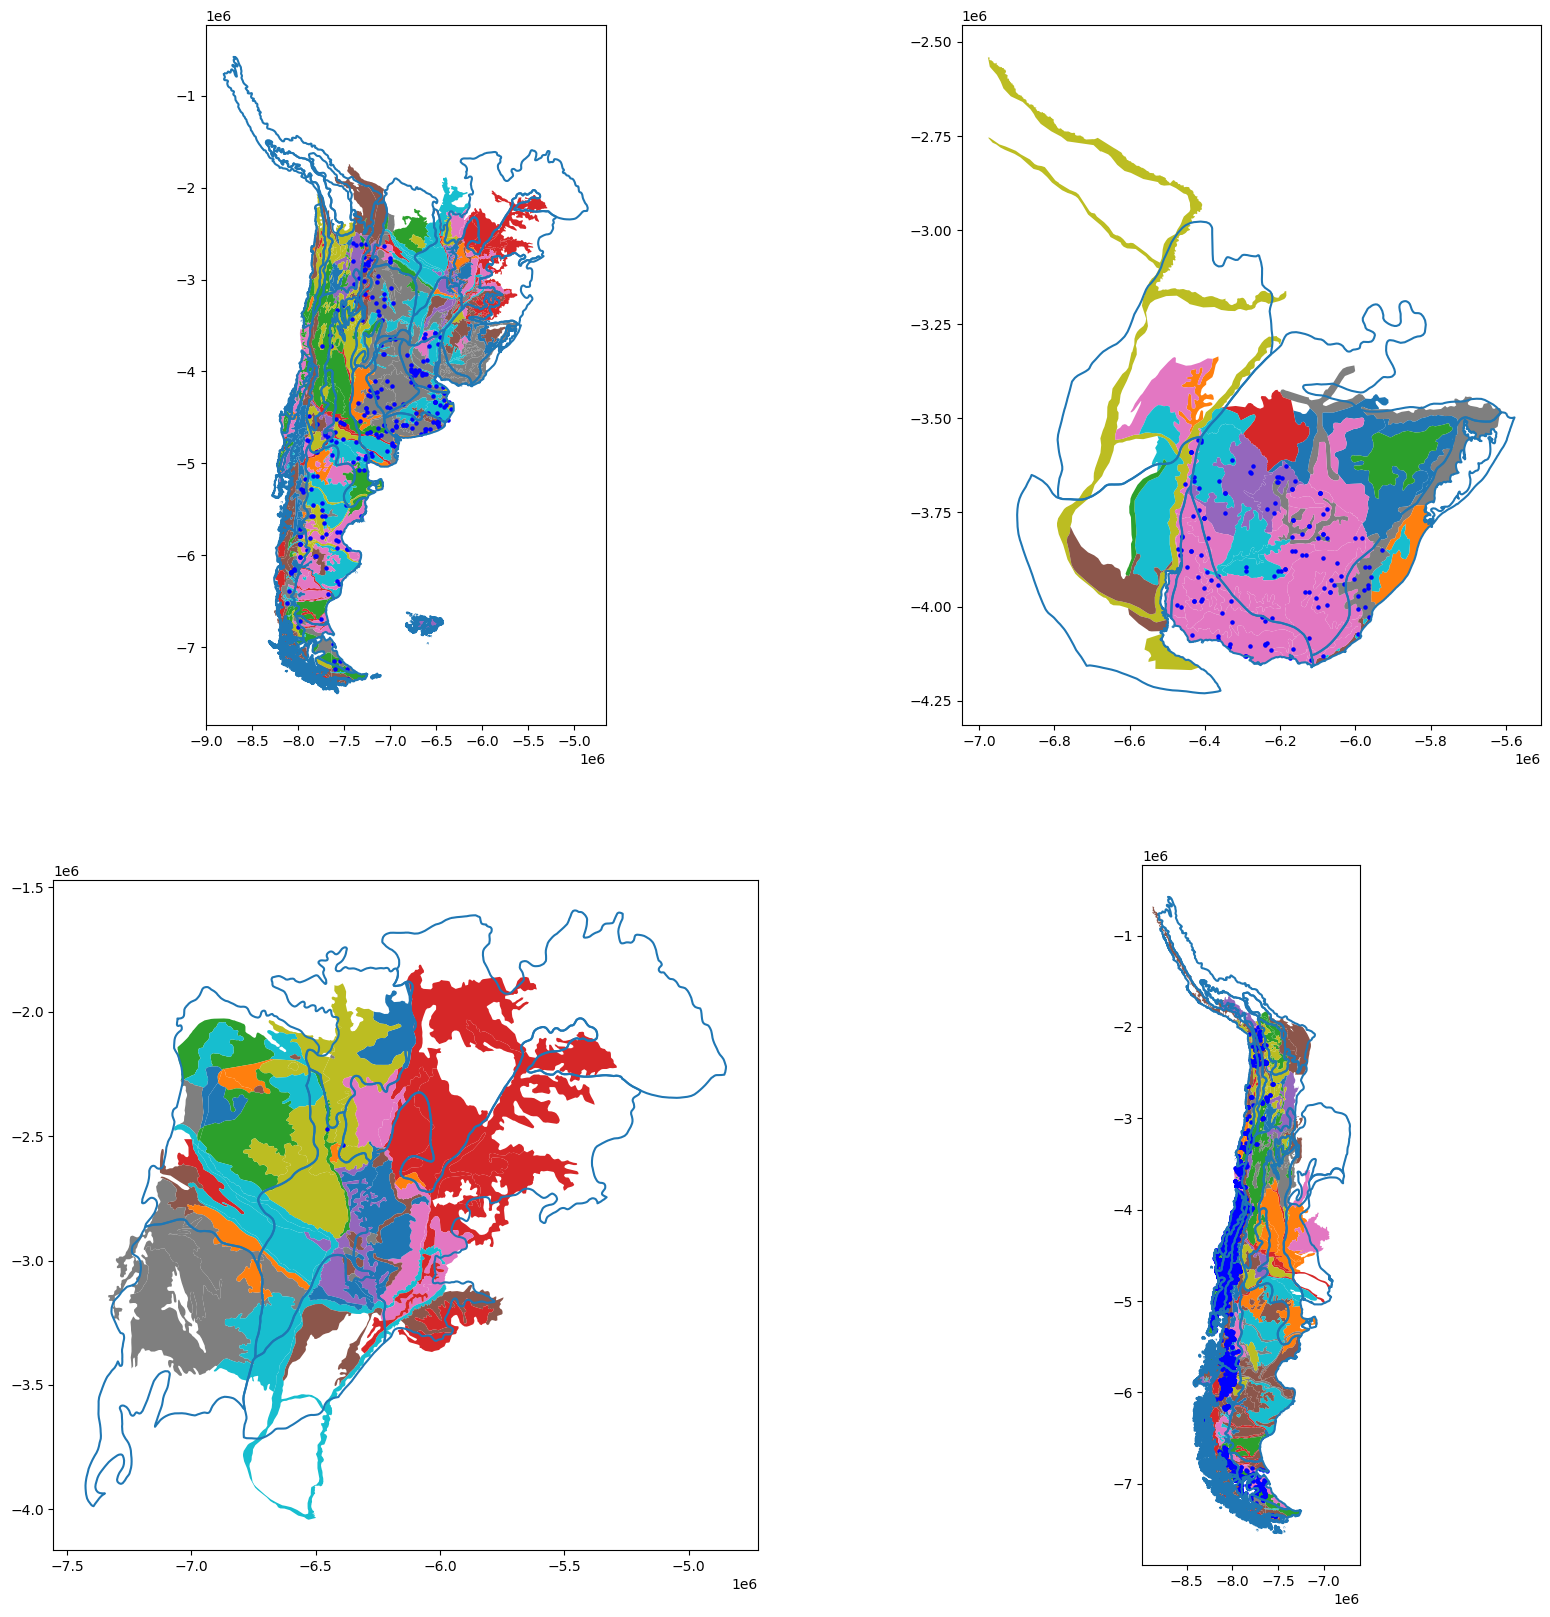

In [81]:
bboxes = get_bboxes_and_transform()
profiles = get_profiles_and_transform()
n = 2

fig, axes = plt.subplots(n, n, figsize=(20,20))

for i in range(n):
    for j in range(n):
        bbox = bboxes[j+i*n]
        base = gdf_soils.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(column='DOMSOIL_UN', ax=axes[i][j])
        gdf_ecoregions.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].boundary.plot(ax = base)
        profiles[j+i*n].plot(ax=base, marker='o', color='blue', markersize=5)